In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import kernel

t = np.linspace(0, 1, 101)
dim = len(t)
# 2. ランダムシードの固定（再現性のため）
np.random.seed(42)
n_samples = 30
use_kernel = kernel.integrated_brownian


In [3]:
mean = np.array([0] * dim)
cov = use_kernel(t)
mean_br, cov_br = kernel.bridge_kernel(t, use_kernel, y=1)

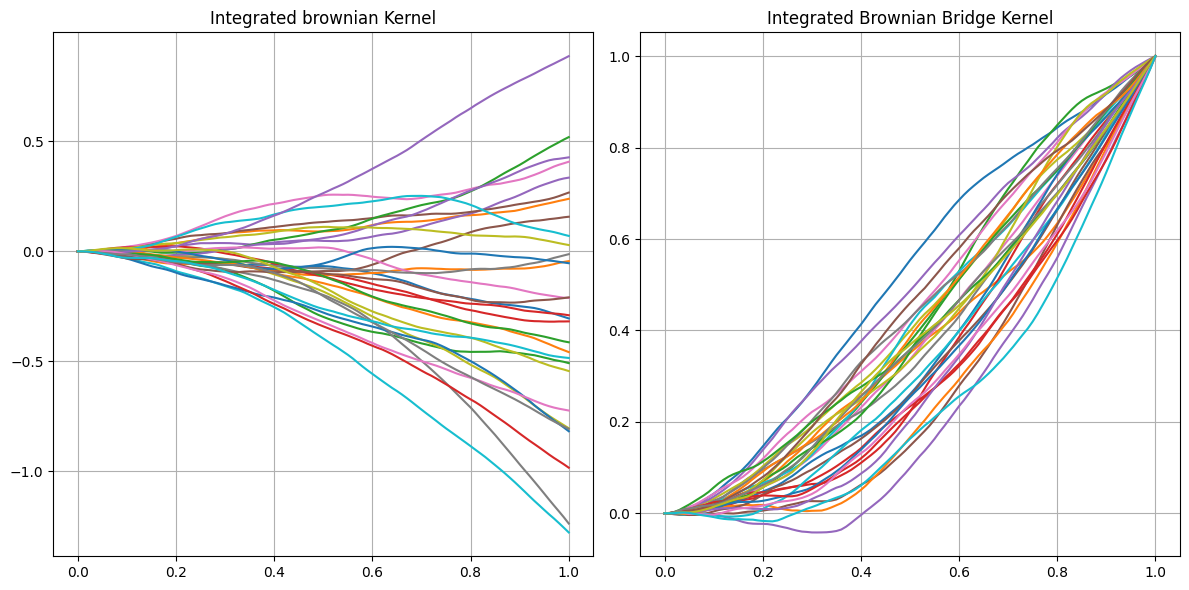

In [4]:
# 1行2列のサブプロットを作成 (figsizeで横長に設定)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# --- 1つ目のプロット (左側: axes[0]) ---
data = np.random.multivariate_normal(mean, cov, n_samples)
for ft in data:
    axes[0].plot(t, ft)
axes[0].set_title("Integrated brownian Kernel")
axes[0].grid(True)

# --- 2つ目のプロット (右側: axes[1]) ---
data = np.random.multivariate_normal(mean + mean_br, cov_br, n_samples)
for ft in data:
    axes[1].plot(t, ft)
axes[1].set_title("Integrated Brownian Bridge Kernel")
axes[1].grid(True)

plt.tight_layout()  # レイアウトの重なりを自動調整
plt.show()

In [5]:
from eot import (
    compute_entropic_ot_coupling,
    sample_from_coupling,
)
import matplotlib.pyplot as plt
from matplotlib import gridspec

In [6]:
grid, pi, pdf1, pdf2 = compute_entropic_ot_coupling()

In [7]:
samples = sample_from_coupling(pi, grid, 50)

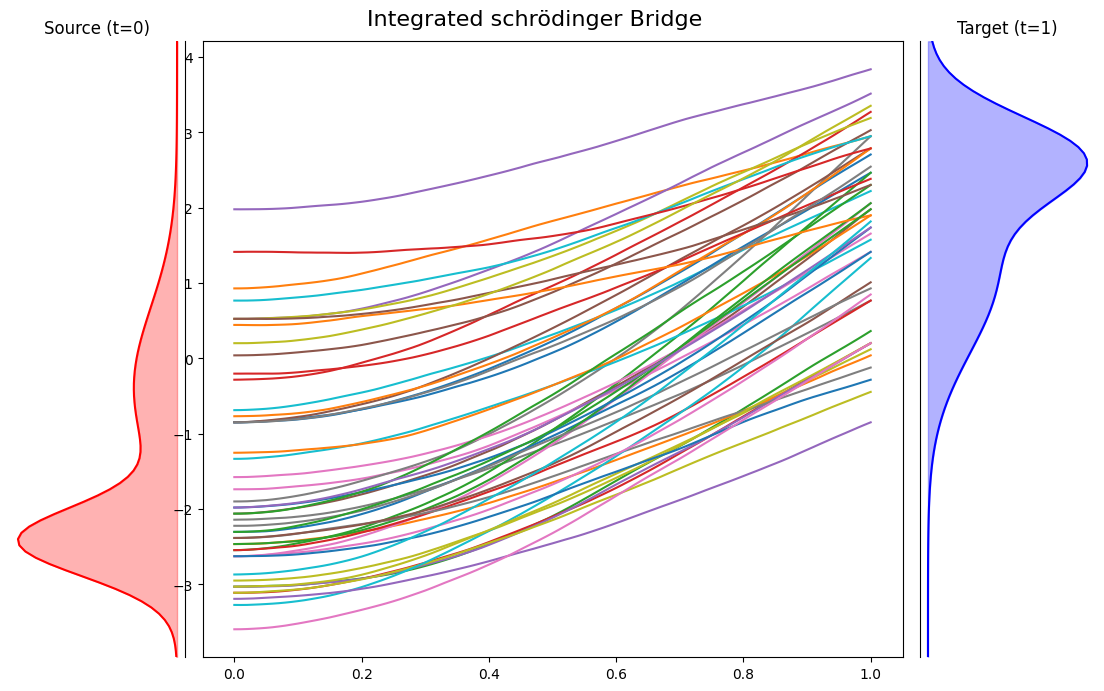

In [ ]:
# --- 3. 可視化 ---
fig = plt.figure(figsize=(14, 8)) # 横幅を広めに調整

# グリッドレイアウトの定義 (1行3列)
# width_ratiosで中央を広く、左右を狭く (分布1 : ブリッジ4 : 分布1)
gs = gridspec.GridSpec(
    1, 3, width_ratios=[1, 4, 1], wspace=0.05, hspace=0.05
)

# --- 3. 左の領域: ソース分布 pdf1 (縦軸 y -> 90度回転) ---
ax_left = plt.subplot(gs[0, 0])
ax_left.plot(pdf1, grid, color="red", label="Source")
ax_left.fill_betweenx(grid, 0, pdf1, color="red", alpha=0.3)
ax_left.set_ylim(-4, 4)
ax_left.invert_xaxis()  # 分布の「山」を中心（右側）に向けるため、0を右、最大値を左にする
ax_left.set_xticks([])  
ax_left.set_yticks([])  # 中央と共有するので消すか、必要なら残す
ax_left.spines["top"].set_visible(False)
ax_left.spines["left"].set_visible(False)
ax_left.spines["bottom"].set_visible(False)
ax_left.set_title("Source (t=0)", fontsize=12)
# --- 2. 右の領域: ターゲット分布 pdf2 (縦軸 y -> 270度回転) ---
ax_right = plt.subplot(gs[0, 2])
ax_right.plot(pdf2, grid, color="blue", label="Target") # 色を青に変更して区別
ax_right.fill_betweenx(grid, 0, pdf2, color="blue", alpha=0.3)
ax_right.set_ylim(-4, 4)
# ここでは invert_xaxis しない -> 0が左（中央側）、山が右（外側）へ向く
ax_right.set_xticks([])
ax_right.set_yticks([]) 
ax_right.spines["top"].set_visible(False)
ax_right.spines["right"].set_visible(False)
ax_right.spines["bottom"].set_visible(False)
ax_right.set_title("Target (t=1)", fontsize=12)

# 4. 中央の領域: Schrodinger bridge
ax_main = plt.subplot(gs[0, 1])
# extentで座標軸をグリッドに合わせる
for x, y in samples:
    data = np.random.multivariate_normal(
        x + (cov[:, -1] / cov[-1, -1]) * (y - x), cov_br, 1
    )
    for ft in data:
        ax_main.plot(t, ft)


# タイトルなどを設定
plt.suptitle("smoothed schrödinger Bridge", y=0.92, fontsize=16)
plt.show()